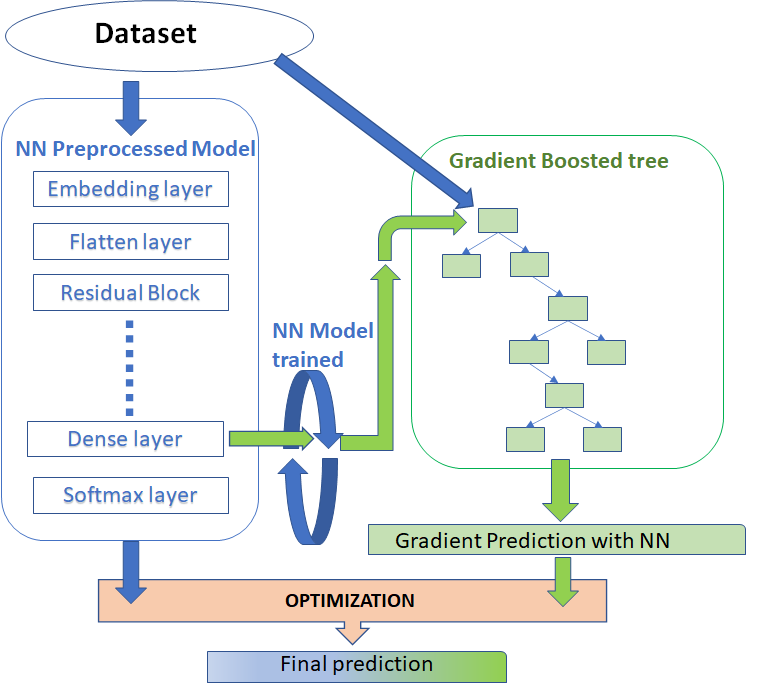

<h3>Neural Network and Gradient boosting compete and we take the best with optimization or blending

In [ ]:
!pip install tensorflow_decision_forests
import tensorflow_decision_forests as tfdf
import os
import math

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import log_loss


import gc

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations,callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers

from keras.models import Model


In [ ]:
train = pd.read_csv('../input/tabular-playground-series-jun-2021/train.csv')
test = pd.read_csv("../input/tabular-playground-series-jun-2021/test.csv")
submission = pd.read_csv("../input/tabular-playground-series-jun-2021/sample_submission.csv")
submission = submission.set_index('id')


In [ ]:
# targets for the NN with Onehot encoding and target with labelencoding for Gradient
targets = pd.get_dummies(train['target'])
dic = {'Class_1':0,'Class_2':1,'Class_3':2,'Class_4':3,'Class_5':4,'Class_6':5,'Class_7':6,'Class_8':7,'Class_9':8}
target = train["target"].map(dic)
train["target"] = target

In [ ]:
def custom_metric(y_true, y_pred):
    y_pred = K.clip(y_pred, 1e-15, 1-1e-15)
    loss = K.mean(cce(y_true, y_pred))
    return loss

cce = tf.keras.losses.CategoricalCrossentropy()

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_custom_metric', min_delta=1e-05, patience=6, verbose=0,
    mode='min', baseline=None, restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_custom_metric', factor=0.7, patience=2, verbose=0,
    mode='min')

In [ ]:
y_valids = []

oof_NN_a = np.zeros((train.shape[0],9))
pred_NN_a = np.zeros((test.shape[0],9))

oof_NN_g = np.zeros((train.shape[0],9))
pred_NN_g = np.zeros((test.shape[0],9))

NN_g_train_preds = []
NN_g_test_preds = []

NN_a_train_preds = []
NN_a_test_preds = []

N_FOLDS = 3
SEED = 41
EPOCH = 60

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state= SEED)

for fold, (tr_idx, ts_idx) in enumerate(skf.split(train,target)):
    print(f"\n--------TRAINING FOLD {fold} ---------\n")

    X_train = train.iloc[:,1:-1].iloc[tr_idx]
    y_train = targets.iloc[tr_idx]
    y_train1 = target.iloc[tr_idx]
    X_test = train.iloc[:,1:-1].iloc[ts_idx]
    y_test = targets.iloc[ts_idx]
    y_test1 = target.iloc[ts_idx]

    K.clear_session()

    conv_inputs = layers.Input(shape = (75))
    embed = layers.Embedding (input_dim = 354, 
                  output_dim = 7,
                  embeddings_regularizer='l2')(conv_inputs)
    embed = layers.Conv1D(12,1,activation = 'relu')(embed)        
    embed = layers.Flatten()(embed)
    hidden = layers.Dropout(0.3)(embed)

    hidden = tfa.layers.WeightNormalization(
        layers.Dense(
        units=32,
        activation ='selu',
        kernel_initializer = "lecun_normal"))(hidden)

    output = layers.Dropout(0.3)(layers.Concatenate()([embed, hidden]))
    output = tfa.layers.WeightNormalization(
    layers.Dense(
        units = 32,
        activation='relu',
        kernel_initializer = "lecun_normal"))(output) 
    output = layers.Dropout(0.4)(layers.Concatenate()([embed, hidden, output]))
    output1 = tfa.layers.WeightNormalization(
    layers.Dense(
        units = 32, 
        activation = 'relu',
        kernel_initializer = "lecun_normal"))(output)

    conv_outputs = layers.Dense(
        units = 9, 
        activation ='softmax',
        kernel_initializer ="lecun_normal")(output1)

    model_conv = Model(conv_inputs,conv_outputs)

    #================= NN CONV MODEL training ========
    
    print("\nTraining of NN model starting\n")
    model_conv.compile(loss='categorical_crossentropy', 
    optimizer = keras.optimizers.Adam(learning_rate=2e-4), 
    metrics=custom_metric)
    model_conv.fit(X_train, y_train,
    batch_size = 256, epochs = EPOCH,
    validation_data=(X_test, y_test),
    callbacks=[es, plateau],
    verbose = 0)

    #============== Convolution Model prediction =======

    pred_a = model_conv.predict(X_test)
    oof_NN_a[ts_idx] += pred_a 
    score_NN_a = log_loss(y_test, pred_a)
    pred_NN_a += model_conv.predict(test.iloc[:,1:]) / N_FOLDS
    
    #=============== Gradient input preparation  ========

    # We take the output1 layer of the NN to feed the Gradient Boosting
    nn_model_without_head = tf.keras.models.Model(inputs=model_conv.inputs,
                            outputs=output1)
    param = {
    'preprocessing': nn_model_without_head,
    'use_hessian_gain':True,
    'selective_gradient_boosting_ratio':0.2,
    'categorical_algorithm':'RANDOM', 
    'num_trees': 300,
    'selective_gradient_boosting_ratio':0.2,
    'subsample': 0.7870499728626467,
    'shrinkage': 0.018653897565237845,
    'max_depth' : 3,
    'min_examples' : 11,
    'l1_regularization': 3.5480988121992953,
    'l2_categorical_regularization': 0.11074398839677566
    }

    model_Gradient_with_NN = tfdf.keras.GradientBoostedTreesModel(**param)

    #==================== Gradient training  =============

    print("\nTraining of GBT with NN model starting\n")
    metrics = [tf.keras.metrics.CategoricalCrossentropy()]
    model_Gradient_with_NN.compile(metrics=metrics)
    model_Gradient_with_NN.fit(np.array(X_train),np.array(y_train1))

    #================= GBT Model prediction ==============

    pred_g = model_Gradient_with_NN.predict(X_test)
    oof_NN_g[ts_idx] += pred_g
    score_GBT_NN = log_loss(y_test1, pred_g)
    print(f"\nFOLD {fold} Score of NN Model alone: {score_NN_a}")
    print(f"\nFOLD {fold} Score of GBT after NN : {score_GBT_NN}\n")
    pred_NN_g += model_Gradient_with_NN.predict(test.iloc[:,1:]) / N_FOLDS

    # =========PREPROCESSING FOR FUTURE OPTIMIZATION======

    y_valid = target.iloc[ts_idx]
    y_valids.append(y_valid)

    NN_a_train_preds.append(pred_a)
    NN_a_test_preds.append(model_conv.predict(test.iloc[:,1:]))

    NN_g_train_preds.append(pred_g)
    NN_g_test_preds.append(model_Gradient_with_NN.predict(test.iloc[:,1:]))

print ("\n***************************************************")
score_a = log_loss(targets, oof_NN_a)
print(f"\n FINAL SCORE NN MODEL ALONE : {score_a}")
score_NN_g = log_loss(target, oof_NN_g)
print(f"\n FINAL SCORE GBT MODEL AFTER NN: {score_NN_g}")
print ("\n***************************************************")

In [ ]:
from scipy.optimize import minimize
scores = []
weights = []
for y, NN_a_pred,NN_g_pred in zip( y_valids,  
                                   NN_a_train_preds,
                                   NN_g_train_preds                
                                    ):
    preds = []
    preds.append(NN_a_pred)
    preds.append(NN_g_pred)
    
    def log_weight_loss(weights):
        weighted_pred = ((weights[0]*preds[0]) + (weights[1]*preds[1]))
        return log_loss(y, weighted_pred)
    starting_values = [10]*len(preds) 
    cons = ({'type':'eq','fun':lambda w: 1-sum(w)})
    #bounds = [(0,1)]*len(preds) 
    res = minimize(log_weight_loss, 
                   starting_values, 
                   method='Nelder-Mead', 
                   #bounds=bounds, 
                   constraints=cons)
    
    weights.append(res['x'])
    scores.append(res['fun'])

In [ ]:
results = pd.DataFrame(weights, columns =['Model NN','Model GBT'])
results['better model'] = results.idxmax(axis=1, skipna=True)
results ['max_value'] = results.max(axis=1)
results['scores'] = scores
display(results)

In [ ]:
results.groupby(['better model'])['max_value'].count()

In [ ]:
folds = N_FOLDS
final_weights = sum(weights)/(folds)
weighted_preds = np.array((final_weights[0] * sum(np.array(NN_a_test_preds)/(folds)))
                           +(final_weights[1] * sum(np.array(NN_g_test_preds)/(folds))))

In [ ]:
submission[['Class_1', 'Class_2', 'Class_3', 'Class_4','Class_5','Class_6','Class_7','Class_8','Class_9']] = weighted_preds
submission.to_csv('weighted5.csv')

In [ ]:
submission[['Class_1', 'Class_2', 'Class_3', 'Class_4','Class_5','Class_6','Class_7','Class_8','Class_9']] = (pred_NN_g + pred_NN_a)/2
submission.to_csv('blend3.csv')

In [ ]:
submission[['Class_1', 'Class_2', 'Class_3', 'Class_4','Class_5','Class_6','Class_7','Class_8','Class_9']] = pred_NN_g
submission.to_csv('gradient1.csv')